# Hi, kagglers!

**Note 1** *Sorry for my english, and non-optimized code*

**Note 2** *I used there just one thing from notebook of some guy, and can't find it again to make a reference :( (it's scatter + kde plot design)*

**Note 3** *Kurt would have loved python :)*
**Note 4** *Copy of my first nb, baut just added*

It is my work for CLRP Competition! I hope you'll get something useful there.
My name is Yuri, I'm novice on Kaggle :) 
Also I need some help, I tell it in the last cell of this nb.
Waiting your point by comment;)

In [1]:
%pip install textstat
%pip install eng_to_ipa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from math import ceil
from collections import Counter
import nltk
from nltk import pos_tag
import eng_to_ipa as ipa
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error as MSE
import re
import textstat
# from tqdm import tqdm
# import torch
# import transformers as ppb

     |████████████████████████████████| 99 kB 752 kB/s 
     |████████████████████████████████| 2.0 MB 2.7 MB/s 
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 2.8 MB 594 kB/s 
  Created wheel for eng-to-ipa: filename=eng_to_ipa-0.0.2-py3-none-any.whl size=2822636 sha256=818a8d812674c983b8b0563ef24e7c22cccac7344c38524ce79d578ba068d03c
  Stored in directory: /root/.cache/pip/wheels/96/c0/dd/aeddfbebc2c3301c3dd09670d9954b0574ac4cd982664c1110
Successfully built eng-to-ipa
Note: you may need to restart the kernel to use updated packages.


# Description
Can machine learning identify the appropriate reading level of a passage of text, and help inspire learning? Reading is an essential skill for academic success. When students have access to engaging passages offering the right level of challenge, they naturally develop reading skills.

Currently, most educational texts are matched to readers using traditional readability methods or commercially available formulas. However, each has its issues. Tools like Flesch-Kincaid Grade Level are based on weak proxies of text decoding (i.e., characters or syllables per word) and syntactic complexity (i.e., number or words per sentence). As a result, they lack construct and theoretical validity. At the same time, commercially available formulas, such as Lexile, can be cost-prohibitive, lack suitable validation studies, and suffer from transparency issues when the formula's features aren't publicly available.

CommonLit, Inc., is a nonprofit education technology organization serving over 20 million teachers and students with free digital reading and writing lessons for grades 3-12. Together with Georgia State University, an R1 public research university in Atlanta, they are challenging Kagglers to improve readability rating methods.

In this competition, you’ll build algorithms to rate the complexity of reading passages for grade 3-12 classroom use. To accomplish this, you'll pair your machine learning skills with a dataset that includes readers from a wide variety of age groups and a large collection of texts taken from various domains. Winning models will be sure to incorporate text cohesion and semantics.

If successful, you'll aid administrators, teachers, and students. Literacy curriculum developers and teachers who choose passages will be able to quickly and accurately evaluate works for their classrooms. Plus, these formulas will become more accessible for all. Perhaps most importantly, students will benefit from feedback on the complexity and readability of their work, making it far easier to improve essential reading skills. 

# Evaluation

Submissions are scored on the root mean squared error. RMSE is defined as:
# $ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \widehat{y_i})^2} $
where is the predicted value,   is the original value, and   is the number of rows in the test data.

# First glance
Let us say, there are $m$ different excerpts, so its $T = \{ t_1, t_2, ..., t_m \}$.
Also we could use $k$ omnifarious features: $X = \{ x_1, x_2, ..., x_k \}$. Obviously, the set $X$ is countable, cause we able to use all operations to create new features by olds. So we have $n$ estimators of our excerpts. (We assume that all assessors used their own model and participated in each assessment)
Finally, $D = \{ d_1, d_2, ..., d_k \}$, where $d_i$ is amount of using $x_i$, $ i\in N$, $i\in [1, k]$, and $f: X\leftrightarrow D$ 

*Example:* Let $n=2$, and $ M_1(x_1, x_2, x_4)$ & $ M_2(x_1, x_4, x_5)$ - models of estimators 1 & 2, $x_1(t_i), x_2(t_i), x_3(t_i), x_4(t_i), x_5(t_i)$ - features applied to the text $t_i$. We also guess, that $x$ features transformed to some kind that: $M_1 = x_1 + x_2 + x_4$, $M_2 = x_1 + x_4 + x_5$. If we think that final model is: $M = \frac{M_1 + M_2}{2}$, we have $d_1 = 2$, $d_2 = 1$, $d_3 = 0$, $d_4 = 2$, $d_5 = 1$ 

We get: $y_j = \frac{1}{n}\sum_{i=1}^{k}d_ix_i(t_j)$, where: $d_i\in Z$, $d_i\in [0, n]$
Or: $y_j = \sum_{i=1}^{k}p_ix_i(t_j)$, where: $p_i\in [0, 1]$, $p_i$ is frequency or probability of using $x_i$, $p_i=1$ - everyone used, and, accordingly, $p_i=0$ - no one.

This would be a good model using probabilities as weights, but the idea is too simple to be true. Getting a large number of features, single estimators using different models, a variable number of estimators evaluating excerpts etc.- the model is more complex than we thought. 

And later we saw this...

> Hi everyone, 
Wanted to post this so it be nearer the top. I have posted similar items in various discussions, but the discussion board is very healthy and I am afraid they are getting lost.
The target value is the result of a Bradley-Terry analysis of more than 111,000 pairwise comparisons between excerpts. Teachers spanning grades 3-12  a majority teaching between grade 6-10 served as the raters for these comparisons.
Standard error is included as an output of the Bradley-Terry analysis because individual raters saw only a fraction of the excerpts, while every excerpt was seen by numerous raters. The test and train sets were split after the target scores and s.e. were computed.
Great to see such a spirited competition!

Scott Crossley, competition host

"Target is the result of a Bradley-Terry analysis of more than 111,000 pairwise comparisons between excerpts..."
Obviously, 111000 less than $\binom{m}{2}$, also "readability" of text, should be positive number, to be compared by Bradley-Terry, but we have negative as well. And we have interesting dependence between index and target:
# $index \approx \frac{length}{(e^{target+mt}+1)^n}$
where $mt$ is median of target, and $n$ is something like curvature factor

In [2]:
tt = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
tn = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
tn.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
totalen = tt.shape[0] + tn.shape[0]
(totalen + 1)/2, (totalen * (totalen - 1)) / 2

(1421.0, 4034220.0)

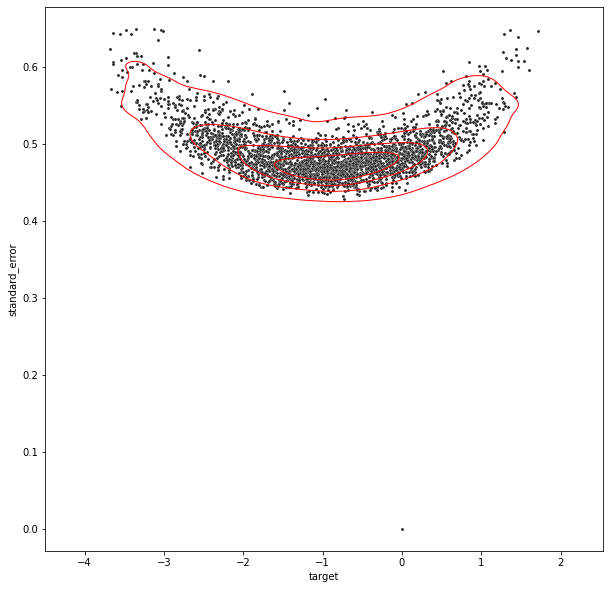

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=tn.target, y=tn.standard_error, s=10, color=".15")
sns.kdeplot(x=tn.target, y=tn.standard_error, levels=5, color="r", linewidths=1)
plt.show()

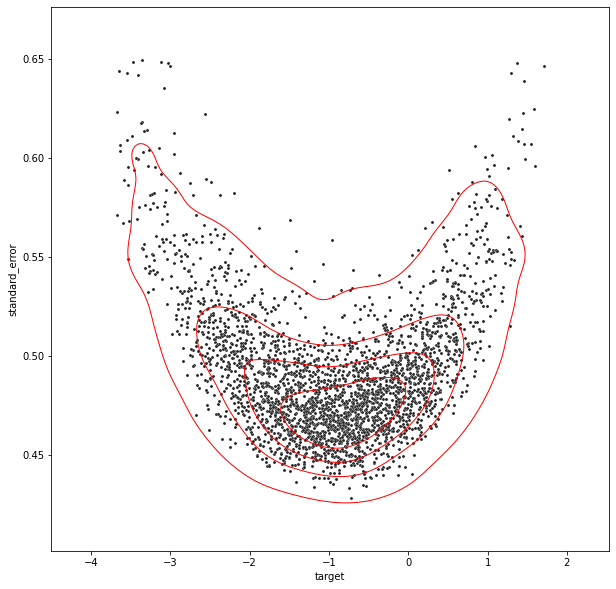

In [5]:
tn = tn.drop(tn[tn.standard_error == 0].index[0])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=tn.target, y=tn.standard_error, s=10, color=".15")
sns.kdeplot(x=tn.target, y=tn.standard_error, levels=5, color="r", linewidths=1)
plt.show()

In [6]:
sorted_tn = tn.sort_values('target', ascending=False)
sorted_tn.index = range(len(sorted_tn))
sorted_tn

,id,url_legal,license,excerpt,target,standard_error
0,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
1,849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
2,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776
3,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997
4,016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600
...,...,...,...,...,...,...
2828,9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822
2829,284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
2830,fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
2831,493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404


In [7]:
# these features was getting during the first running in txt_values() func
# I uploaded its there (ttt.csv), because ipa.convert() works so long...
sorted_tn[['t_length', 'coeff']] = pd.read_csv('../input/length/ttt.csv').drop('Unnamed: 0', axis=1)

Now we're seeing this:
# $index \approx \frac{length}{(e^{target+mt}+1)^n}$
Also we able to know $n$, but we shouldn't care about it at all
So graph below:

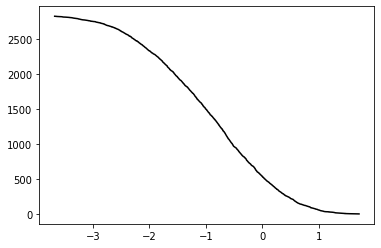

In [8]:
plt.plot(sorted_tn.target, sorted_tn.index, 'black')

In [9]:
tn.license.unique()

array([nan, 'CC BY-SA 3.0 and GFDL', 'CC BY-SA 3.0', 'CC BY 4.0',
       'CC BY-NC', 'CC BY-NC-SA 2.0', 'CC BY-NC 3.0', 'CC BY-NC-ND 4.0',
       'CC BY NC-SA 2.0', 'CC BY-NC 2.0', 'CC-BY-SA', 'CC-BY-NC',
       'CC BY 3.0', 'GNU Free Document License, version 1.2',
       'CC BY-NC-SA 3.0', 'CC BY-NC-SA 4.0'], dtype=object)

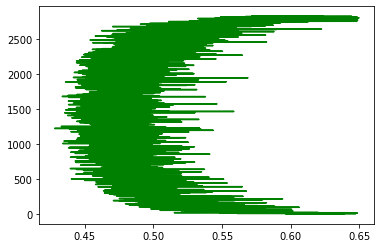

In [10]:
plt.plot(sorted_tn.standard_error, sorted_tn.index, 'g')

In [11]:
unq_lisence = dict()
number = 1
for k in sorted_tn.license.unique():
    unq_lisence[k] = number
    number += 1

def licensed(value):
    return unq_lisence[value]

In [12]:
links = sorted_tn[sorted_tn.url_legal.isnull() == False].url_legal.unique()

In [13]:
links_set = set()
for link in links:
    pattern = r'://[a-z, 0-9 | \.]+/'
    site = re.findall(pattern, link)[0][3:-1]
    links_set.add(site)

In [14]:
lists_dict = {}
number = 1
for k in sorted(links_set):
    lists_dict[k] = number
    number += 1    
lists_dict

{'beyondpenguins.ehe.osu.edu': 1,
 'drive.google.com': 2,
 'emedia.uen.org': 3,
 'en.wikibooks.org': 4,
 'en.wikipedia.org': 5,
 'freekidsbooks.org': 6,
 'kids.frontiersin.org': 7,
 'simple.wikipedia.org': 8,
 'sites.ehe.osu.edu': 9,
 'static.ehe.osu.edu': 10,
 'ukuqonda.co.za': 11,
 'www.africanstorybook.org': 12,
 'www.ck12.org': 13,
 'www.commonlit.org': 14,
 'www.digitallibrary.io': 15}

In [15]:
def link_distrib(value):
    
    if isinstance(value, str):
        for k, v in lists_dict.items():
            if value[8:].startswith(k):
                return v
    return 0

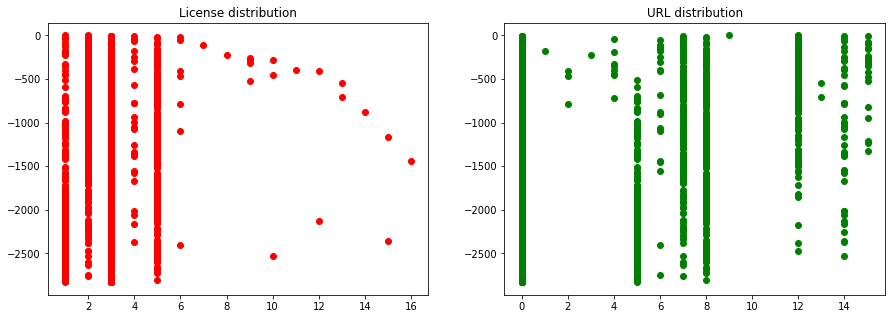

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(15, 5))

axes[0].set(title='License distribution')
axes[0].plot(sorted_tn.license.apply(licensed), [-i for i in range(len(sorted_tn))], 'ro')
axes[1].set(title='URL distribution')
axes[1].plot(sorted_tn.url_legal.apply(link_distrib), [-i for i in range(len(sorted_tn))], 'go')

In [17]:
tt.url_legal.apply(link_distrib), lists_dict

(0     0
 1     0
 2     0
 3     5
 4     5
 5     0
 6    12
 Name: url_legal, dtype: int64,
 {'beyondpenguins.ehe.osu.edu': 1,
  'drive.google.com': 2,
  'emedia.uen.org': 3,
  'en.wikibooks.org': 4,
  'en.wikipedia.org': 5,
  'freekidsbooks.org': 6,
  'kids.frontiersin.org': 7,
  'simple.wikipedia.org': 8,
  'sites.ehe.osu.edu': 9,
  'static.ehe.osu.edu': 10,
  'ukuqonda.co.za': 11,
  'www.africanstorybook.org': 12,
  'www.ck12.org': 13,
  'www.commonlit.org': 14,
  'www.digitallibrary.io': 15})

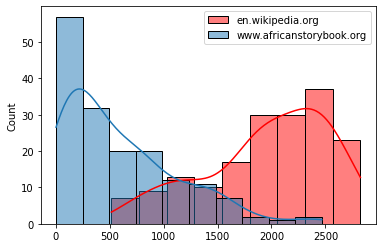

In [18]:
k = 0

indices5, indices12 = [], []
for url in sorted_tn.url_legal:
    if isinstance(url, str):
        if url[8:].startswith('en.wikipedia.org'):
            indices5.append(k)
        elif url[8:].startswith('www.africanstorybook.org'):
            indices12.append(k)
    k += 1

sns.histplot(indices5, kde=True, color="r", label='en.wikipedia.org')
sns.histplot(indices12, kde=True, label='www.africanstorybook.org')
plt.legend()

In [19]:
def txt_values(text, test=False, with_tags=False):
    
    text = text.lower()
       
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    sentences, words, tags = [], [], []
    ind_1 = 0
    for ind_2 in range(len(text)):
        if text[ind_2] == '.' or text[ind_2] == '!' or text[ind_2] == '?':
            if text[ind_2 - 1] != '.' or text[ind_2] != '!' or text[ind_2] != '?':
                sentences.append(text[ind_1:ind_2])
                ind_1 = ind_2
    sentences = [sentences[0]] + list(map(lambda x: x[2:], sentences[1:]))
        
    for sentence in sentences:
         words += re.findall(pattern, sentence)
            
    if test:
#         I used ipa with train when was the first running. It locates in ttt.csv
        transcripted = ''
        for word in words:
            transcripted += ipa.convert(word).replace(':', '').replace("'", '').replace('.', '')    
            
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    
    if test:
        t_text_length = len(transcripted)
        
    text_length = len(''.join(words))
    nof_syllables = textstat.syllable_count(text)
    nof_words = len(words)
    nof_sentences = len(sentences)
    avg_len_syllable = text_length / nof_syllables
    avg_len_word = text_length / nof_words
    avg_len_sentence = text_length / nof_sentences
    gunning = textstat.gunning_fog(text)
    ari = textstat.automated_readability_index(text)
    coliau = textstat.coleman_liau_index(text)
    lwf = textstat.linsear_write_formula(text)
    FR_ease = 206.835 - 1.015 * (nof_words / nof_sentences) - 84.6 * (nof_syllables / nof_words)
    FK_level = 0.39 * (nof_words / nof_sentences) + 11.8 * (nof_syllables / nof_words) - 15.59
    
    if with_tags:
        tags_percentage = {}
        for key, value in Counter(tags).items():
            tags_percentage[key] = value / nof_words
    
        for tag in possible_tags:
            if tag not in tags_percentage.keys():
                tags_percentage[tag] = 0
    
        if test:
            return pd.Series([text_length, t_text_length, t_text_length / text_length, nof_syllables,
                              nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                              avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf] + sorted(tags_percentage.values()))   
    
        return pd.Series([text_length, nof_syllables,
                          nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                          avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf] + sorted(tags_percentage.values()))
    
    if test:
        return pd.Series([text_length, t_text_length, t_text_length / text_length, nof_syllables,
                        nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                        avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf])
    
    return pd.Series([text_length, nof_syllables,
                          nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                          avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf])
        
        

features = ['text_length', 't_length', 'coeff', 'nof_syllables', 'nof_words',
           'nof_sentences', 'avg_len_syllable', 'avg_len_word',
           'avg_len_sentence', 'FR_ease', 'FK_level', 'gunning', 'ari', 
           'coliau', 'lwf']


sorted_tn[[features[0]] + features[3:]] = sorted_tn.excerpt.apply(txt_values)
tt[features] = tt.excerpt.apply(txt_values, test=True)

# sorted_tn[[features[0]] + features[3:] + possible_tags] = sorted_tn.excerpt.apply(txt_values, with_tags=True)
# tt[features + possible_tags] = tt.excerpt.apply(txt_values, test=True, with_tags=True)

In [20]:
assert len(sorted_tn.columns) - 2 == len(tt.columns), 'Strange'

In [21]:
def show_diffs(dataframe, features, figsize=(20, 20), reversed_inds=True):
    
    n = -1 if reversed_inds else 1
    x = ceil(np.sqrt(len(features)))
    fig, axes = plt.subplots(nrows=x, ncols=x, figsize=figsize)
    for i in range(len(features)):
        axes[i // x][i % x].set(title='Feature: ' + features[i])
        axes[i // x][i % x].plot(dataframe[features[i]], n * dataframe.index)
    
    return plt.plot()

[]

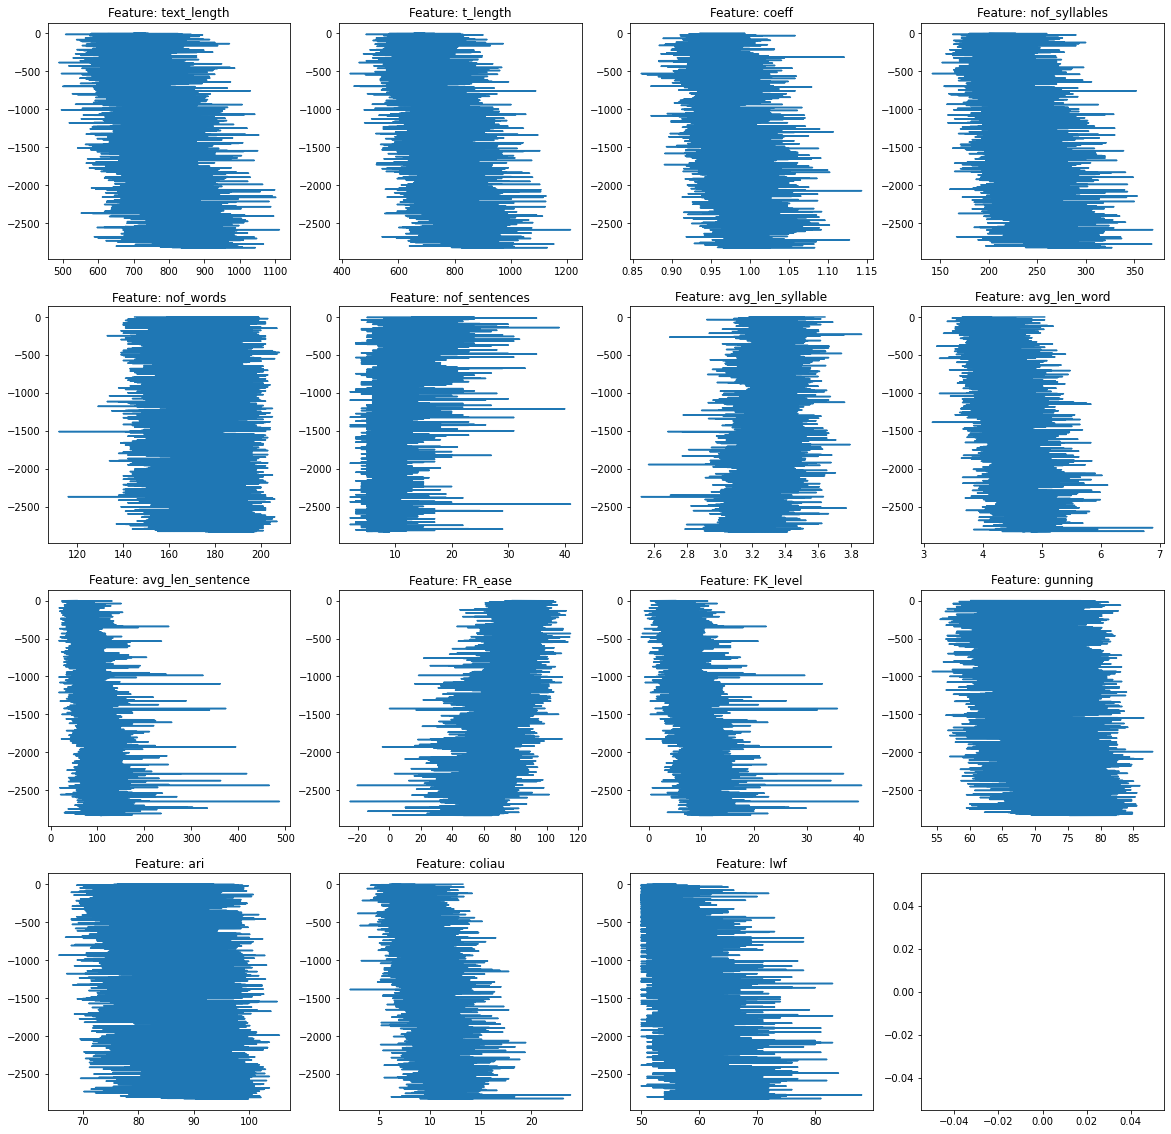

In [22]:
# reverse index for better understanding of dependencies
show_diffs(sorted_tn, features)

In [23]:
# first text, the easiest one
sorted_tn.loc[0].excerpt

'When you think of dinosaurs and where they lived, what do you picture? Do you see hot, steamy swamps, thick jungles, or sunny plains? Dinosaurs lived in those places, yes. But did you know that some dinosaurs lived in the cold and the darkness near the North and South Poles?\nThis surprised scientists, too. Paleontologists used to believe that dinosaurs lived only in the warmest parts of the world. They thought that dinosaurs could only have lived in places where turtles, crocodiles, and snakes live today. Later, these dinosaur scientists began finding bones in surprising places.\nOne of those surprising fossil beds is a place called Dinosaur Cove, Australia. One hundred million years ago, Australia was connected to Antarctica. Both continents were located near the South Pole. Today, paleontologists dig dinosaur fossils out of the ground. They think about what those ancient bones must mean.'

In [24]:
# the hardest
sorted_tn.loc[sorted_tn.shape[0] - 1].excerpt

'The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be found. These three segments are made so as to be removable in a moment for cleaning or replacement. They are mounted upon a metal support, and are surrounded on all sides by a free air space, and cannot, therefore, lose their insulated condition. This feature of air insulation is peculiar to this system, and is very important as a factor in the durability of the commutator. Besides this, the commutator is sustained by supports carried in flanges upon the shaft, which flanges, as an additional safeguard, are coated all over with hard rubber, one of the finest known insulators. It may be stated, without fear of contradiction, that no other commutator made is so thoroughly insulated and protected. The three commutator segments virtually constitute a single copper ring, mounted i

# Next idea of the feature to be extracted. It's something like "good order" feature.

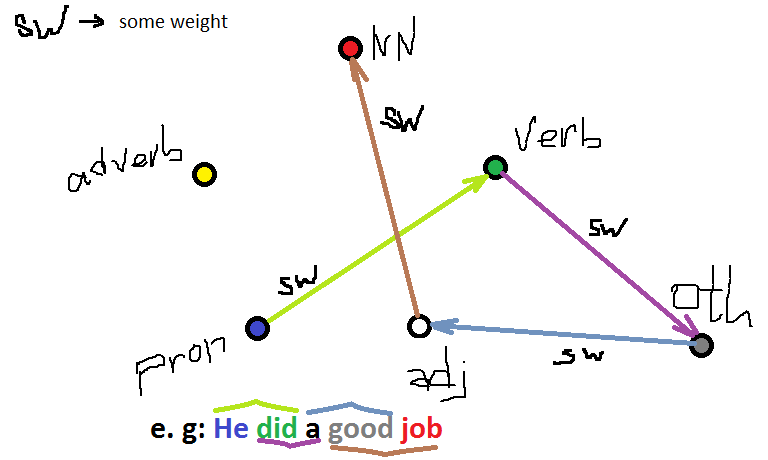

We just count $\sum_{w=1}^{l}sw_i$, Where $ l $ is length of ecxerpt, $sw$ is a single value, not multiplied.
So next step is counting $sw$ as a frequency of the same two-pos sequences 

In [25]:
tagdict = nltk.data.load('help/tagsets/upenn_tagset.pickle')
possible_tags = sorted([i for i in tagdict.keys() if i.isupper()])

In [26]:
def tagtag(text):
    
    text = text.lower()
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    words = re.findall(pattern, text)
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    return tags

In [27]:
tag2tag = {}
for i in range(sorted_tn.shape[0]):
    tag_list = tagtag(sorted_tn.excerpt[i])
    for j in range(len(tag_list) - 1):
        dbletag = tag_list[j] + tag_list[j + 1]
        if dbletag in tag2tag.keys():
            tag2tag[dbletag] += 1
        else:
            tag2tag[dbletag] = 1

In [28]:
wsum = sum(tag2tag.values())
for i in tag2tag:
    tag2tag[i] /= wsum

In [29]:
new_tag2tag = {k: v for k, v in sorted(tag2tag.items(), key=lambda x: x[1], reverse=True)}

In [30]:
leng = sorted_tn.shape[0]
def tag_to_tag(text):
    
    number = 0
    text = text.lower()
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    words = re.findall(pattern, text)
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    for j in range(len(tags) - 1):
        dbletag = tags[j] + tags[j + 1]
        number += new_tag2tag[dbletag]
    
    return number

In [31]:
sorted_tn['to_tag'] = sorted_tn.excerpt.apply(tag_to_tag)
tt['to_tag'] = tt.excerpt.apply(tag_to_tag)

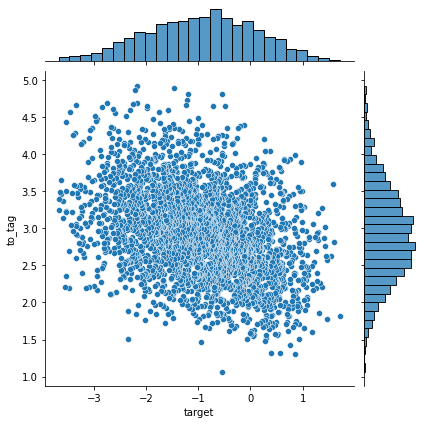

In [32]:
sns.jointplot(sorted_tn.target, sorted_tn.to_tag)

In [33]:
sorted_tn

,id,url_legal,license,excerpt,target,standard_error,t_length,coeff,text_length,nof_syllables,...,avg_len_syllable,avg_len_word,avg_len_sentence,FR_ease,FK_level,gunning,ari,coliau,lwf,to_tag
0,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,727,0.993169,732.0,201.0,...,3.641791,5.048276,56.307692,78.240743,5.117241,60.21,75.7,13.25,56.0,1.821222
1,849971671,https://www.africanstorybook.org/,CC BY 4.0,"For her last birthday, Sisanda had a special t...",1.597870,0.596349,655,0.935714,700.0,207.0,...,3.381643,4.216867,50.000000,89.304819,3.748744,66.73,82.0,8.61,53.0,2.810265
2,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,"Every day, Emeka's father took him to school i...",1.583847,0.624776,695,0.936658,742.0,228.0,...,3.254386,3.824742,37.100000,97.562696,2.061041,77.01,93.6,6.29,52.0,3.593076
3,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,More people came to the bus stop just before 9...,1.541672,0.606997,567,0.977586,580.0,180.0,...,3.222222,3.647799,24.166667,104.337040,0.352241,62.66,76.2,6.00,51.0,2.624799
4,016913371,https://www.africanstorybook.org/,CC BY 4.0,Grandma's garden was wonderful. It was full of...,1.467665,0.599600,821,0.993947,826.0,260.0,...,3.176923,4.150754,39.333333,86.684003,3.522800,79.03,97.3,8.55,56.0,2.612914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2828,9e9eacb49,NaN,NaN,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822,826,0.966082,855.0,268.0,...,3.190299,4.672131,106.875000,59.721793,10.612124,78.60,94.9,10.70,59.0,3.460029
2829,284eaa5ad,NaN,NaN,As to surface-slope its measurement—from nearl...,-3.639936,0.603819,973,1.015658,958.0,314.0,...,3.050955,5.150538,136.857143,37.045645,14.693287,79.47,96.0,14.24,72.0,3.656101
2830,fe44cbd14,NaN,NaN,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398,946,0.992655,953.0,309.0,...,3.084142,5.069149,119.125000,43.932500,12.969681,82.34,99.7,12.90,58.0,3.482507
2831,493b80aa7,NaN,NaN,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404,936,0.986301,949.0,278.0,...,3.413669,4.817259,105.444444,65.233006,9.598443,79.85,99.8,12.27,54.0,3.387781


In [34]:
cols_to_drop = ['id', 'url_legal', 'license', 'excerpt']
tn_excerpts = sorted_tn.excerpt
tt_excerpts = tt.excerpt

In [35]:
sorted_tn = sorted_tn.drop(cols_to_drop, axis=1)
tt = tt.drop(cols_to_drop, axis=1)

In [36]:
# if interesting, wait few minutes
# sns.pairplot(sorted_tn[sorted_tn.columns])

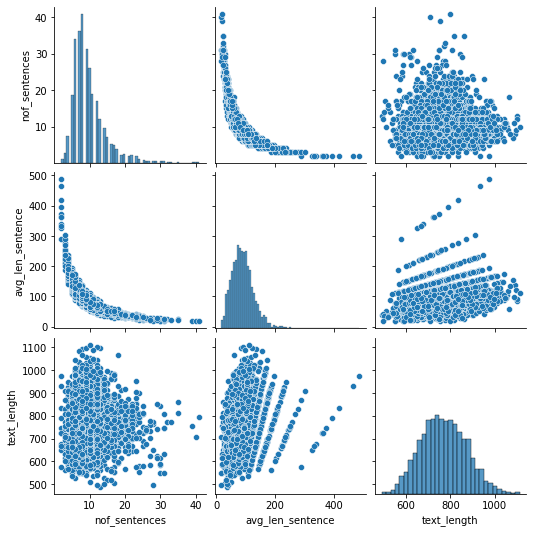

In [37]:
# we have some useless features, at least one of them shown by this example
sns.pairplot(sorted_tn[['nof_sentences', 'avg_len_sentence', 'text_length']])
# later we'll use lasso to know all useless feats

[]

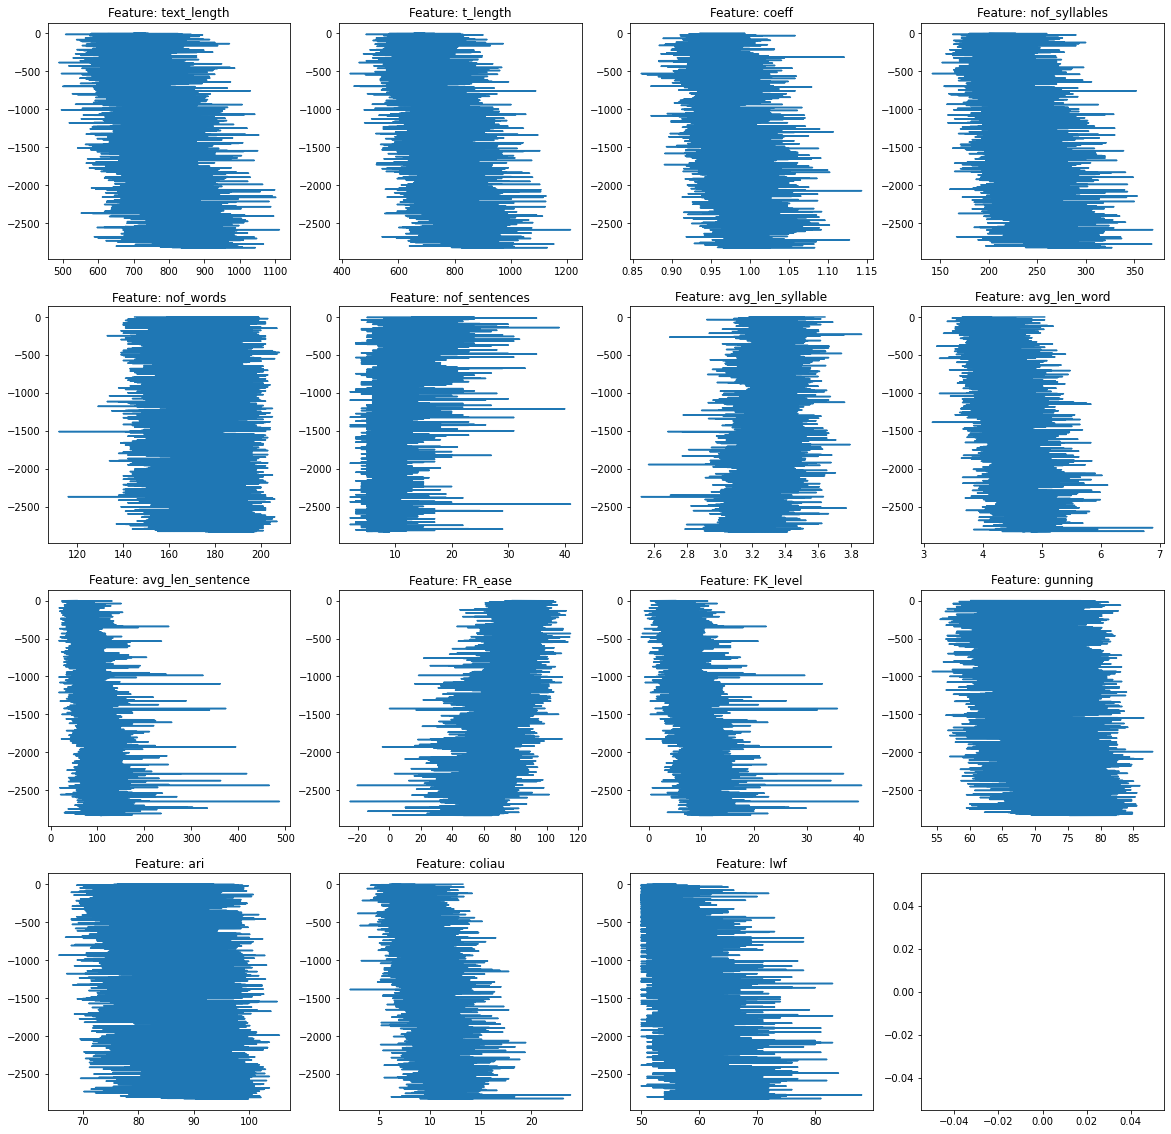

In [38]:
show_diffs(sorted_tn, features)

<AxesSubplot:>

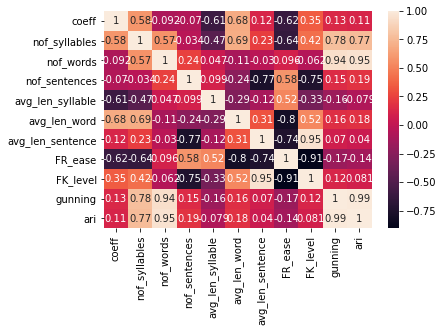

In [39]:
# for now, let's take a look at correlation ratio 
sns.heatmap(sorted_tn[features[2:13]].corr(), annot=True)

Now we're looking a few things 

<AxesSubplot:>

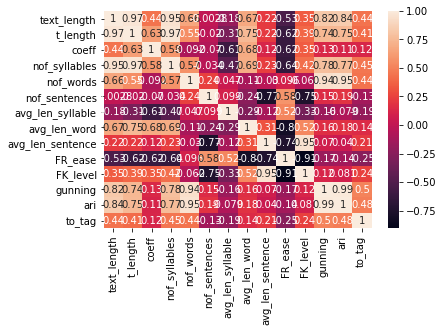

In [40]:
sns.heatmap(sorted_tn[features[:13] + ['to_tag']].corr(), annot=True)

In [41]:
tt_features = []
for j in features:
    if j not in ['standard_error', 'target']:
        tt_features.append(j)

[]

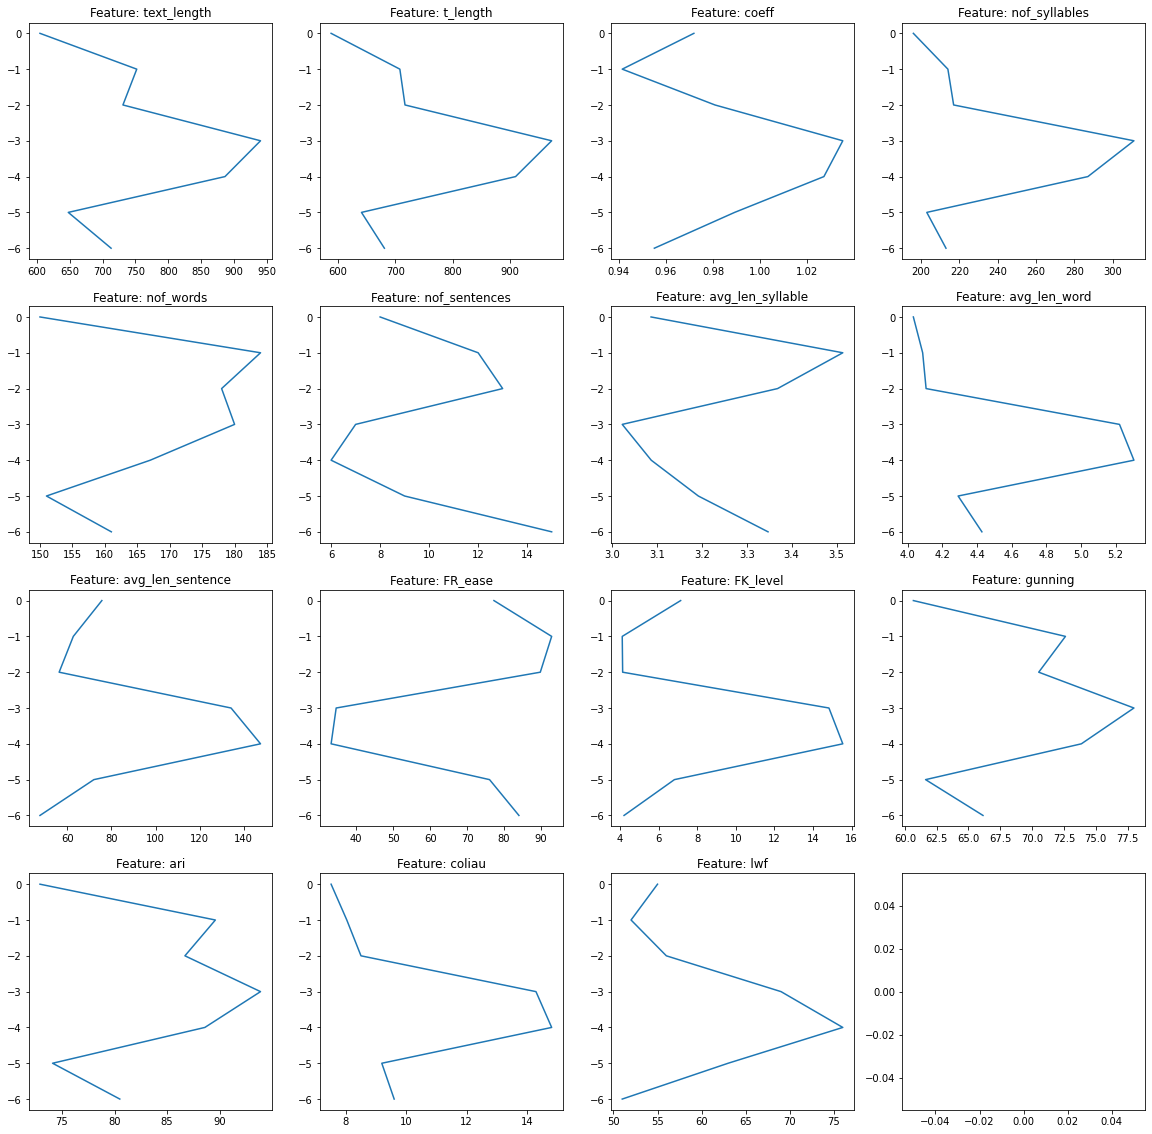

In [42]:
# just interesting :)
show_diffs(tt, tt_features)

# Summary
Now, I'm going to use lasso to get sparse feature vector. Also I want to implement useful features (I'll get by Lasso) into PyTorch transformer with RobertaTokenizer are both at once. But I don't know how to do it :( It, might, something like a training new model with a pretrained one. If U know, please provide me with link, or your work after the competition ends. Need help :)
If interesting, please upvote and sorry again for my eng... 